# PCA

In [1]:
import numpy as np
fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

In [2]:
# n_components -> 주성분 개수
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(fruits_2d)

PCA(n_components=50)

In [3]:
# 50개의 주성분과 10,000개의 특성
print(pca.components_.shape)

(50, 10000)


In [4]:
import matplotlib.pyplot as plt
def draw_fruits(arr, ratio=1):
    n = len(arr) # 샘플 개수
    # 한 줄에 10개씩 이미지 출력
    # 전체 샘플 수를 10으로 나누어 행 개수를 계산
    rows = int(np.ceil(n/10))
    # 행이 2보다 작으면 열의 개수는 샘플 수
    # 아니면 10개로 채운다.
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols,
                           figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n: # n개 까지만 그리기
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

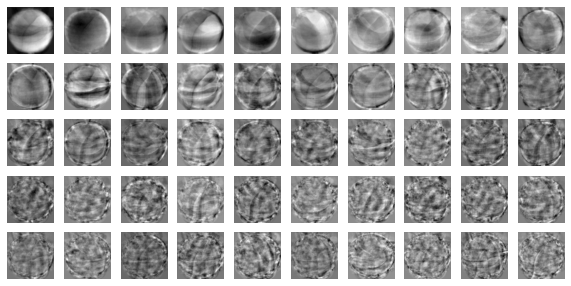

In [5]:
# 주성분 50개
draw_fruits(pca.components_.reshape(-1, 100, 100))

In [6]:
print(fruits_2d.shape)

(300, 10000)


In [7]:
# 원본 데이터의 차원을 50으로 줄여준다.
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


### 원본 데이터 복원

In [8]:
# inverse_transform() 사용
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


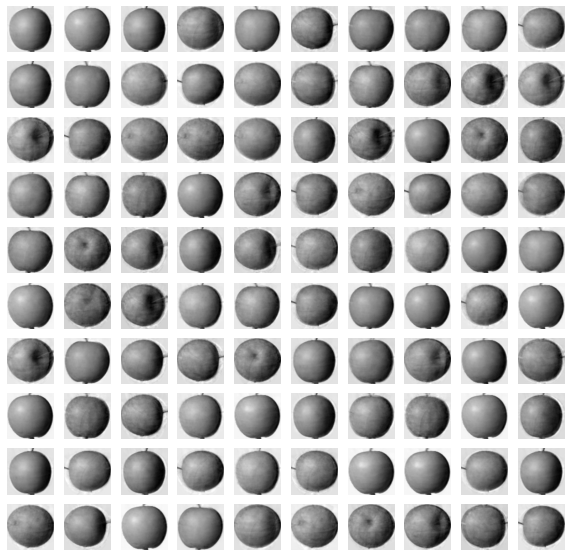

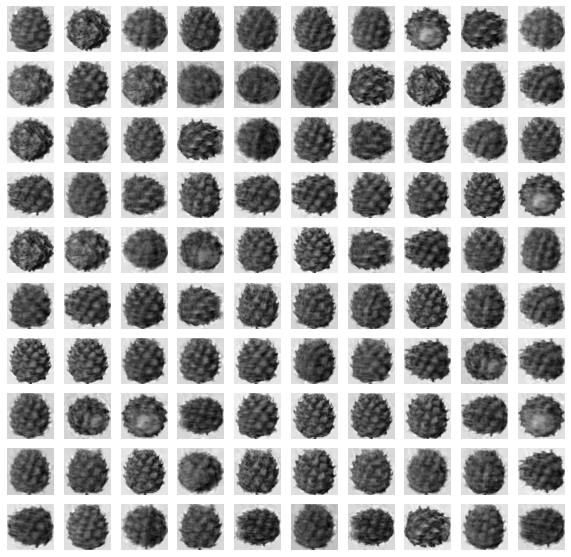

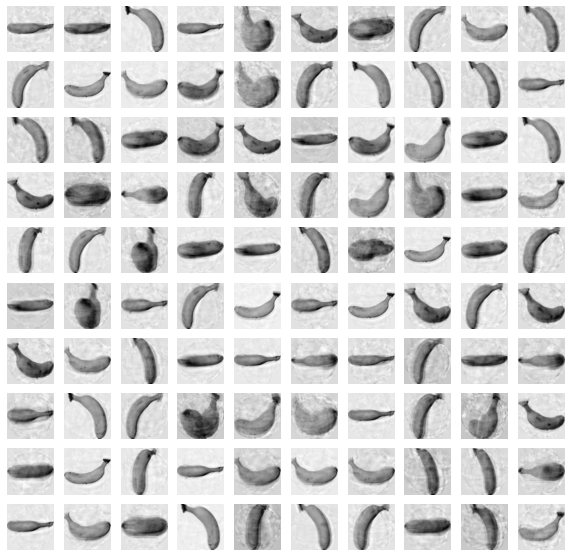

In [9]:
# 복원된 데이터 확인
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)
for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print('\n')

### explained variance

##### 주성분이 원본데이터의 분산을 얼마나 잘 나타내는지 기록한 값을 explained variance라고 한다.
##### explained_variance_ratio_에 각 주성분의 설명된 분산 비율이 기록되어있다.

In [10]:
print(np.sum(pca.explained_variance_ratio_))

0.9214591302872799


##### 92%가 넘는 분산을 유지하고 있다.

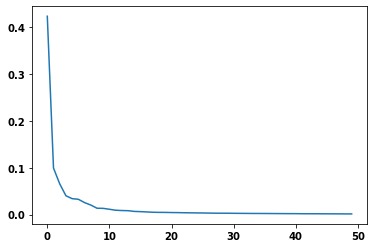

In [11]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

##### 분산이 높은 순서대로 저장되어 있다. 그래프롤 보면 처음 10개의 주성분이 대부분의 분산을 표현하고 있다.

## 축소 차원 적용하기

##### 3개의 과일 사진을 분류하기 위해 로지스틱 회귀 모델을 사용

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [13]:
# target 값 생성, 3종류의 과일
target = np.array([0]*100 + [1]*100 + [2]*100)

In [14]:
# 먼저 원본 데이터 사용, 교차 검증으로 성능 가늠해본다.
from sklearn.model_selection import cross_validate
scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
0.8580834865570068


In [15]:
# PCA로 축소 차원
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

1.0
0.05896382331848145


##### 50개의 특성만 사용했는데 정확도는 100%이고 시간이 엄청나게 줄었다.

In [16]:
# n_components 매개변수에 분산의 비율을 입력할 수도 있다.
# 0~1 사이, 50%의 주성분
pca = PCA(n_components=0.5)
pca.fit(fruits_2d)

PCA(n_components=0.5)

In [17]:
print(pca.n_components_)

2


##### 2개의 주성분으로 데이터에 있는 분산의 50%를 표현할 수 있다.

In [18]:
# 주성분 2개로 데이터 변환
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [19]:
# 2개의 특성으로 교차검증 수행
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

C:\Users\SH\anaconda3\envs\ai\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\SH\anaconda3\envs\ai\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

0.9933333333333334
0.12911972999572754


In [20]:
# k-means 사용
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)
print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2]), array([110,  99,  91], dtype=int64))


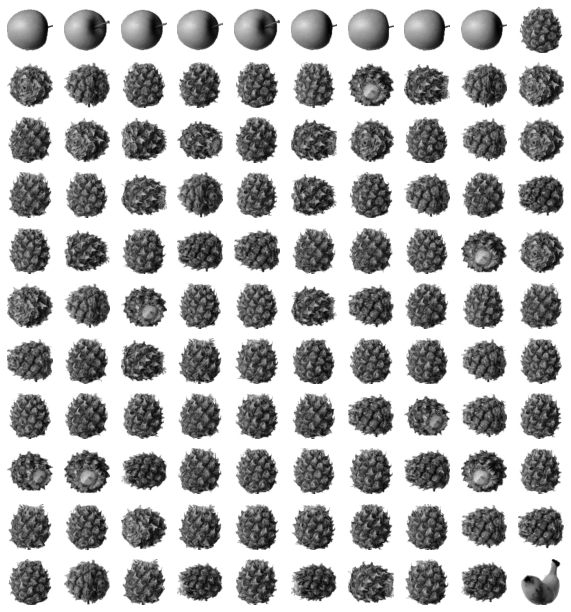

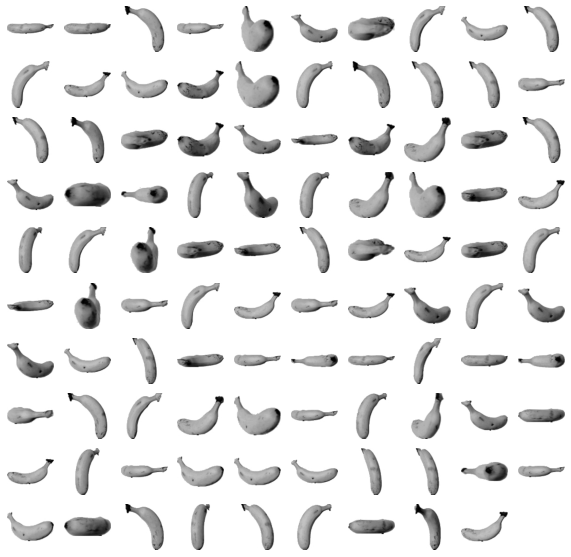

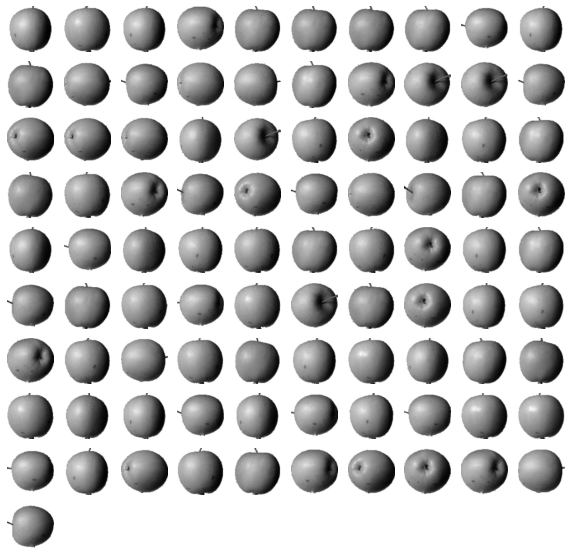

In [21]:
for label in range(0, 3):
    draw_fruits(fruits[km.labels_ == label])
    print("\n")

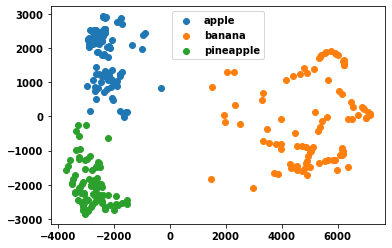

In [22]:
# 산점도로 확인
for label in range(0, 3):
    data = fruits_pca[km.labels_ == label]
    plt.scatter(data[:,0], data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()